In [1]:
import numpy as np
from astropy.table import Table, join, MaskedColumn, vstack, Column
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy
from astropy.time import Time
import pandas as pd
import re
import seaborn as sns
import datetime


from astropy.io import fits

import corner
from numpy import exp
from scipy import integrate
from scipy.integrate import quad
import pdb

from scipy import stats
from scipy.optimize import curve_fit
import scipy.optimize as opt
from multiprocessing import Pool

from scipy.signal import argrelextrema
from scipy.signal import find_peaks

import glob
import lightkurve as lk


from lightkurve.correctors import RegressionCorrector
from lightkurve.correctors import DesignMatrix
from astropy.timeseries import LombScargle

/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_3701/392377372.py:2: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = search[0].download().PDCSAP_FLUX


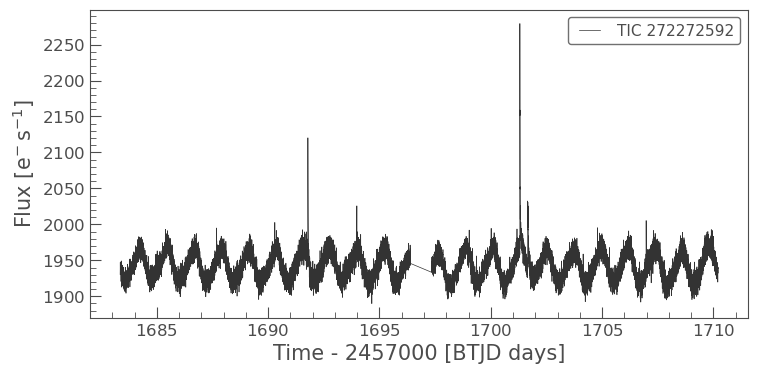

In [2]:
search = lk.search_lightcurve(target='tic272272592', mission='TESS', author='SPOC')
lc = search[0].download().PDCSAP_FLUX
lc=lc[~np.isnan(lc.flux.value)]
lc.plot()
plt.show();

In [3]:
import stella
from tqdm import tqdm_notebook
import os, sys

2023-05-02 16:35:56.989505: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
OUT_DIR='/Users/Tobin/Dropbox/Stellar_Flares_Project/Getting Started/Results/'

In [5]:
cnn = stella.ConvNN(output_dir=OUT_DIR)

Can only use stella.ConvNN.predict().


In [6]:
from stella.download_nn_set import DownloadSets

In [7]:
ds = DownloadSets()
ds.download_models()

Models have already been downloaded to ~/.stella/models


In [8]:
MODELS=ds.models

In [9]:
cnn.predict(modelname='/Users/Tobin/.stella/models/hlsp_stella_tess_ensemblemodel_s000_tess_v0.1.0_cnn.h5',
            times=lc.time.value,
            fluxes=lc.flux.value,
            errs=lc.flux_err.value)
single_pred = cnn.predictions[0]

2023-05-02 16:36:05.114322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 2s 2ms/step


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]


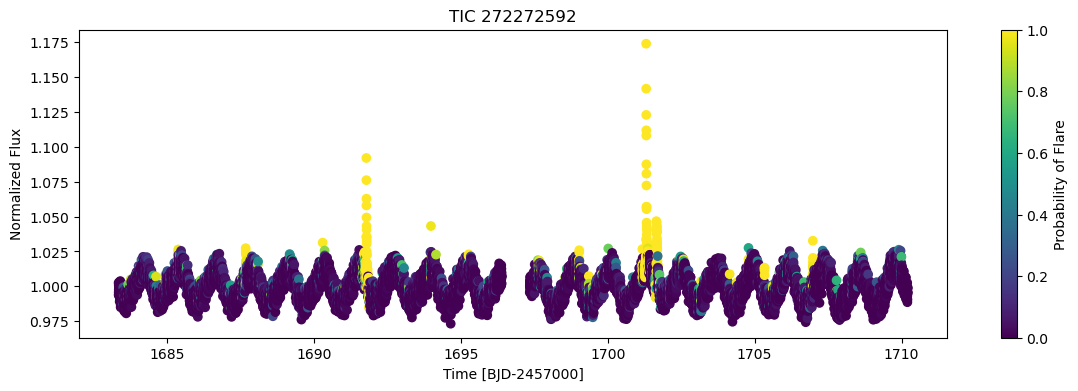

In [10]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=single_pred, vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lc.targetid))
plt.show()

In [11]:
preds = np.zeros((len(MODELS),len(cnn.predictions[0])))

for i, model in enumerate(MODELS):
    cnn.predict(modelname=model,
                times=lc.time.value,
                fluxes=lc.flux.value,
                errs=lc.flux_err.value)
    preds[i] = cnn.predictions[0]

avg_pred = np.nanmedian(preds, axis=0)


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 2s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 2s 3ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


  0%|                                                     | 0/1 [00:00<?, ?it/s]

576/576 [==============================] - 1s 2ms/step


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


In [155]:
x = lc.time.value
y = lc.flux.value

yerr= lc.flux_err.value

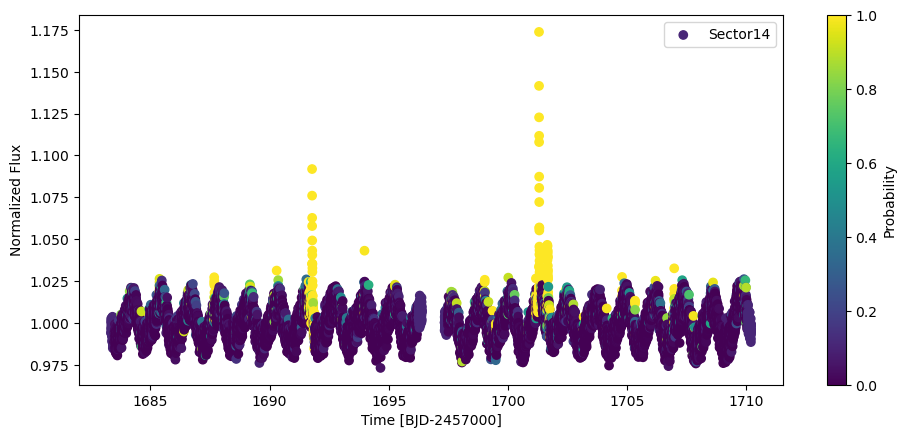

In [12]:
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1, label=('Sector'+str(lc.sector)))
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.colorbar(label='Probability')
plt.legend()
plt.subplots_adjust(right=1.5)
plt.show()

In [13]:
cnn.predict_time[0]

array([1683.35632977, 1683.35771867, 1683.35910758, ..., 1710.20367588,
       1710.20506477, 1710.20645366])

In [112]:
len(bool_above_thresh)

18424

In [132]:
bool_above_thresh=avg_pred > .3


where_flips = [y-x for x, y in zip(np.where(bool_above_thresh[:-1] != bool_above_thresh[1:])[0], np.where(bool_above_thresh[:-1] != bool_above_thresh[1:])[0][1:])]
where_flips

where_flips.insert(0, np.where(bool_above_thresh[:-1] != bool_above_thresh[1:])[0][0])
where_flips.append(len(bool_above_thresh)-np.where(bool_above_thresh[:-1] != bool_above_thresh[1:])[0][-1])

falses_lens=where_flips[::2]

trues_lens=where_flips[1::2]


In [125]:
print(len(falses_lens), len(trues_lens))

207 206


In [169]:
new_flare_boolean=[]

for i in range(len(falses_lens)-1):
    if falses_lens[i] > 20:
        new_flare_boolean.append([False for i in range(falses_lens[i])])
        new_flare_boolean.append([True for i in range(trues_lens[i])])
    else:
        new_flare_boolean.append([True for i in range(falses_lens[i])])
        new_flare_boolean.append([True for i in range(trues_lens[i])])
        
new_flare_boolean.append([False for i in range(falses_lens[-1])])
    

new_bool=np.array([item for sublist in new_flare_boolean for item in sublist])
len(new_bool)

18424

In [154]:
new_where_flips = [y-x for x, y in zip(np.where(new_bool[:-1] != new_bool[1:])[0], np.where(new_bool[:-1] != new_bool[1:])[0][1:])]
new_where_flips

new_where_flips.insert(0, np.where(new_bool[:-1] != new_bool[1:])[0][0])
new_where_flips.append(len(new_bool)-np.where(new_bool[:-1] != new_bool[1:])[0][-1])

new_falses_lens=new_where_flips[::2]

new_trues_lens=new_where_flips[1::2]
new_trues_lens


[2,
 2,
 4,
 1,
 3,
 4,
 3,
 1,
 1,
 9,
 26,
 2,
 9,
 1,
 3,
 20,
 6,
 1,
 1,
 2,
 3,
 3,
 1,
 65,
 3,
 1,
 7,
 1,
 3,
 1,
 15,
 7,
 1,
 3,
 4,
 5,
 7,
 1,
 1,
 5,
 30,
 1,
 189,
 1,
 2,
 1,
 3,
 3,
 1,
 8,
 2,
 1,
 1,
 4,
 3,
 1,
 3,
 3,
 4,
 4,
 3,
 1,
 4,
 2,
 4,
 1,
 25,
 9,
 2,
 4,
 4,
 7,
 1,
 3,
 3,
 3,
 5,
 14,
 3,
 1,
 3,
 3,
 196,
 2,
 10,
 105,
 1,
 1,
 9,
 2,
 5,
 5,
 1,
 7,
 3,
 5,
 3,
 1,
 1,
 2,
 5,
 1,
 5,
 11,
 3,
 1,
 8,
 1,
 1,
 1,
 1,
 12,
 1,
 3,
 1,
 44,
 1,
 1,
 3,
 2,
 4,
 3,
 3,
 9,
 3,
 1,
 5,
 23,
 1]

In [153]:
start_and_stops=[x for x, y in zip(np.where(new_bool[:-1] != new_bool[1:])[0], np.where(new_bool[:-1] != new_bool[1:])[0][1:])]

starts=start_and_stops[::2]
stops=start_and_stops[1::2]
stops.append(starts[-1]+1)

#Testing to make sure this matches the length of the trues
np.array(stops)-np.array(starts)

array([  2,   2,   4,   1,   3,   4,   3,   1,   1,   9,  26,   2,   9,
         1,   3,  20,   6,   1,   1,   2,   3,   3,   1,  65,   3,   1,
         7,   1,   3,   1,  15,   7,   1,   3,   4,   5,   7,   1,   1,
         5,  30,   1, 189,   1,   2,   1,   3,   3,   1,   8,   2,   1,
         1,   4,   3,   1,   3,   3,   4,   4,   3,   1,   4,   2,   4,
         1,  25,   9,   2,   4,   4,   7,   1,   3,   3,   3,   5,  14,
         3,   1,   3,   3, 196,   2,  10, 105,   1,   1,   9,   2,   5,
         5,   1,   7,   3,   5,   3,   1,   1,   2,   5,   1,   5,  11,
         3,   1,   8,   1,   1,   1,   1,  12,   1,   3,   1,  44,   1,
         1,   3,   2,   4,   3,   3,   9,   3,   1,   5,  23,   1])

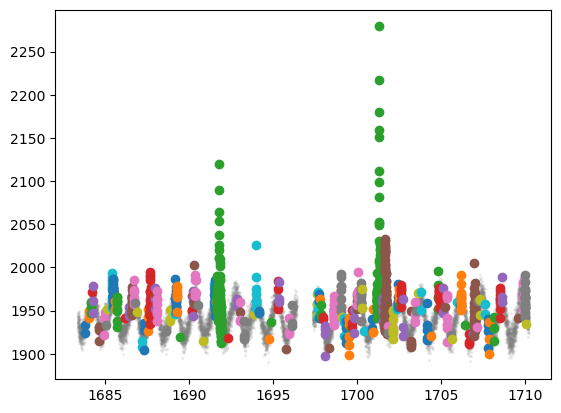

In [158]:
plt.scatter(x,y, color='gray', alpha=.1, label='Sector: 14', s=2)
for i in range(len(starts)):
    ind=range(starts[i], stops[i])
    plt.scatter(x[ind], y[ind])
plt.show()

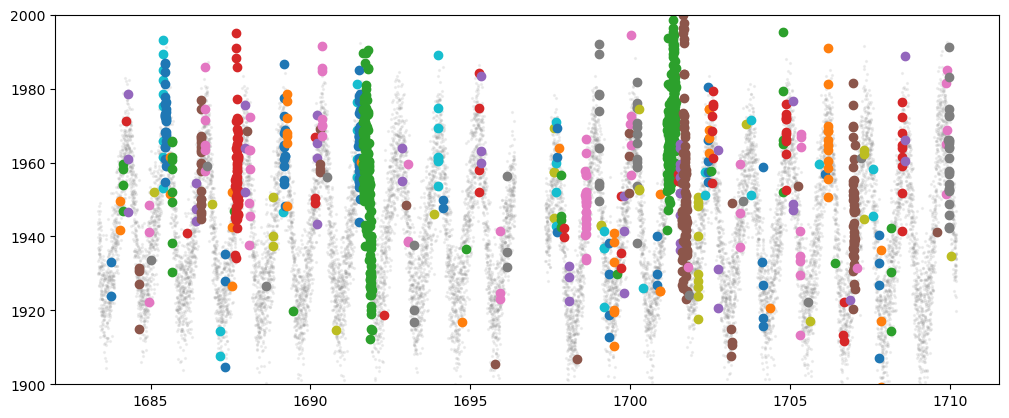

In [160]:
plt.scatter(x,y, color='gray', alpha=.1, label='Sector: 14', s=2)
for i in range(len(starts)):
    ind=range(starts[i], stops[i])
    plt.scatter(x[ind], y[ind])
plt.ylim(1900, 2000)
plt.subplots_adjust(right=1.6)
plt.show()

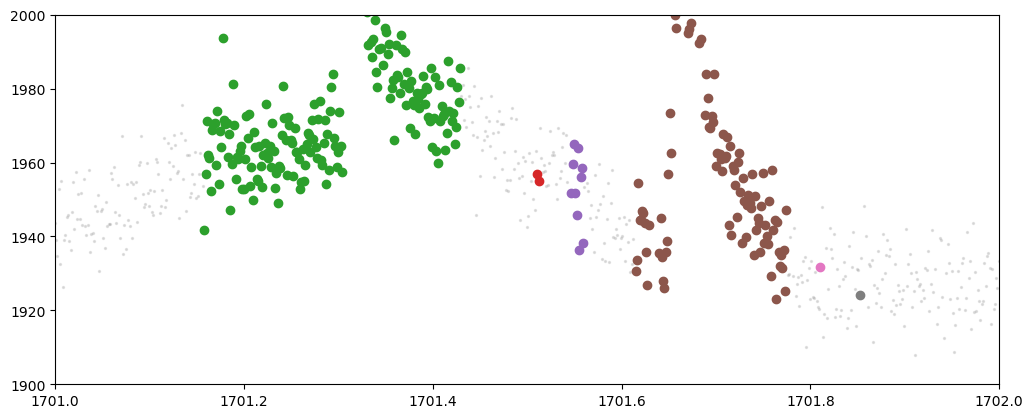

In [163]:
plt.scatter(x,y, color='gray', alpha=.2, label='Sector: 14', s=2)
for i in range(len(starts)):
    ind=range(starts[i], stops[i])
    plt.scatter(x[ind], y[ind])
plt.ylim(1900, 2000)
plt.xlim(1701, 1702)
plt.subplots_adjust(right=1.6)
plt.show()

In [218]:
yerr

MaskedNDArray([8.797657 , 8.782304 , 8.8197975, ..., 8.776901 , 8.799774 ,
               8.784307 ], dtype=float32)

In [170]:
#Only selecting where the length of the flare is greater than 3 data points

v2_flare_boolean=[]

for i in range(len(new_falses_lens)-1):
    if new_trues_lens[i] > 3:
        v2_flare_boolean.append([False for i in range(new_falses_lens[i])])
        v2_flare_boolean.append([True for i in range(new_trues_lens[i])])
    else:
        v2_flare_boolean.append([False for i in range(new_falses_lens[i])])
        v2_flare_boolean.append([False for i in range(new_trues_lens[i])])
        
v2_flare_boolean.append([False for i in range(new_falses_lens[-1])])
        
v2_bool=np.array([item for sublist in v2_flare_boolean for item in sublist])
len(v2_bool)

18424

In [181]:
v2_start_and_stops=[x for x, y in zip(np.where(v2_bool[:-1] != v2_bool[1:])[0], np.where(v2_bool[:-1] != v2_bool[1:])[0][1:])]

v2_starts=v2_start_and_stops[::2][:-1]
v2_stops=v2_start_and_stops[1::2]


#Testing to make sure this matches the length of the trues
np.array(v2_stops)-np.array(v2_starts)

array([  4,   4,   9,  26,   9,  20,   6,  65,   7,  15,   7,   4,   5,
         7,   5,  30, 189,   8,   4,   4,   4,   4,   4,  25,   9,   4,
         4,   7,   5,  14, 196,  10, 105,   9,   5,   5,   7,   5,   5,
         5,  11,   8,  12,  44,   4,   9,   5])

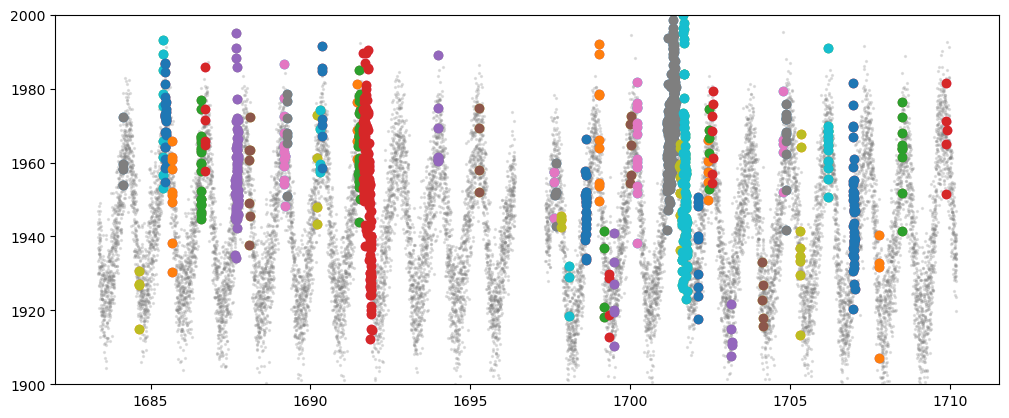

In [182]:
plt.scatter(x,y, color='gray', alpha=.1, label='Sector: 14', s=2)
for i in range(len(v2_starts)):
    ind=range(v2_starts[i], v2_stops[i])
    plt.scatter(x[ind], y[ind])
plt.ylim(1900, 2000)
plt.subplots_adjust(right=1.6)
plt.show()

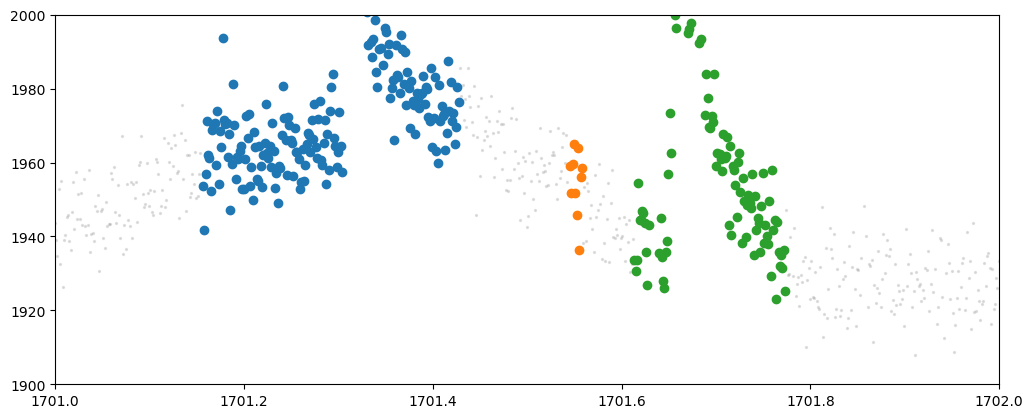

In [183]:
plt.scatter(x,y, color='gray', alpha=.2, label='Sector: 14', s=2)
for i in range(len(v2_starts)):
    ind=range(v2_starts[i], v2_stops[i])
    plt.scatter(x[ind], y[ind])
plt.ylim(1900, 2000)
plt.xlim(1701, 1702)
plt.subplots_adjust(right=1.6)
plt.show()

In [185]:
masked_x=x[~v2_bool]
masked_y=y[~v2_bool]
masked_yerr=yerr[~v2_bool]

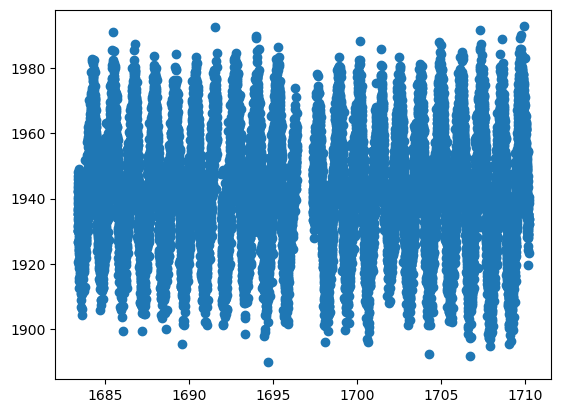

In [186]:
plt.scatter(masked_x, masked_y)
plt.show()

In [187]:
import celerite2
from celerite2 import terms
from scipy.optimize import minimize

# Quasi-periodic term
term1 = terms.SHOTerm(sigma=1.0, rho=1.0, tau=10.0)

# Non-periodic component
term2 = terms.SHOTerm(sigma=1.0, rho=5.0, Q=0.25)
kernel = term1 + term2

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(x, yerr=yerr)

Initial log likelihood: -9315955.183831258


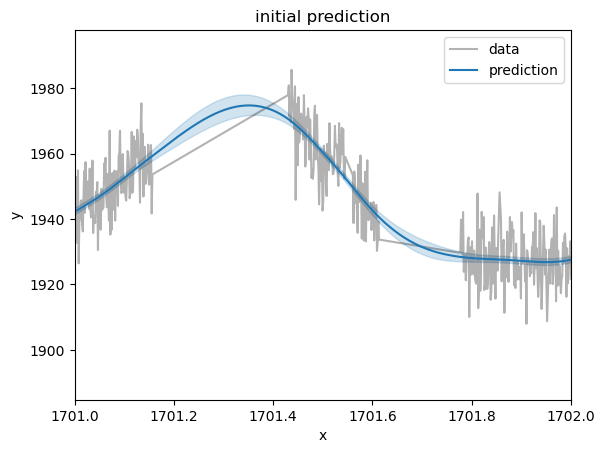

In [221]:
# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(np.array(masked_x), yerr=np.array(masked_yerr))

print("Initial log likelihood: {0}".format(gp.log_likelihood(np.array(masked_y))))

def set_params(params, gp):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = terms.SHOTerm(
        sigma=theta[0], rho=theta[1], tau=theta[2]
    ) + terms.SHOTerm(sigma=theta[3], rho=theta[4], Q=0.25)
    gp.compute(np.array(masked_x), diag=masked_yerr**2 + theta[5], quiet=True)
    return gp


def neg_log_like(params, gp):
    gp = set_params(params, gp)
    return -gp.log_likelihood(np.array(masked_y))


initial_params = [0.0, 0.0, 0.0, np.log(10.0), 0.0, np.log(5.0), np.log(0.01)]
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
opt_gp = set_params(soln.x, gp)
soln

mu=np.zeros(len(x))

def plot_prediction(gp):
    plt.plot(np.array(masked_x), np.array(masked_y), "k", lw=1.5, alpha=0.3, label="data")
    #plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label="truth")

    if gp:
        mu, variance = gp.predict(np.array(masked_y), t=x, return_var=True)
        sigma = np.sqrt(variance)
        plt.plot(x, mu, label="prediction")
        plt.fill_between(x, mu - sigma, mu + sigma, color="C0", alpha=0.2)
        
    plt.xlabel("x")
    plt.ylabel("y")
    #plt.xlim(0, 10)
    #plt.ylim(-2.5, 2.5)
    plt.legend()
    return mu

plt.title("initial prediction")
mu = plot_prediction(opt_gp)
plt.xlim(1701, 1702)
plt.show()

In [222]:
mu

array([1939.06795091, 1938.89163712, 1938.71559951, ..., 1932.03118696,
       1931.89927673, 1931.76810923])

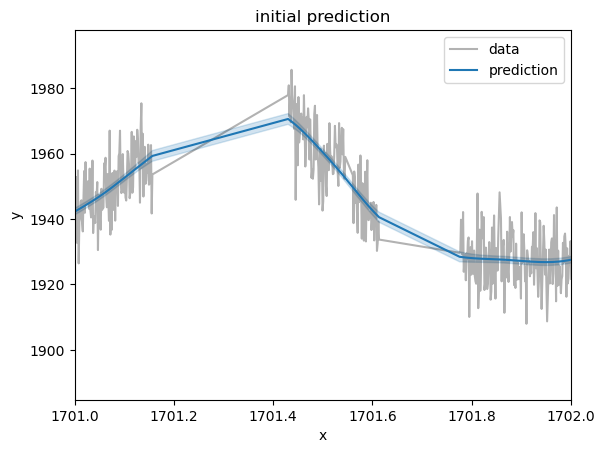

In [192]:
plt.title("initial prediction")
plot_prediction(opt_gp)
plt.xlim(1701, 1702)

plt.show()

In [272]:
# Starting to find the ED's

from scipy import integrate

EDs=np.zeros(len(v2_starts))

for i in range(len(v2_starts)):
    
    flare_ind=range(v2_starts[i], v2_stops[i])
    
    
    #subtracting off the GP:
    
    use_fluxes=(lc.flux.value[flare_ind]-mu[flare_ind])/np.median(lc.flux.value)
    
    flare_energy=integrate.trapezoid(y=use_fluxes, x=lc.time.value[flare_ind])
    
    
    EDs[i]=flare_energy
    
EDs

array([ 2.41827390e-06, -6.32210106e-06,  4.23355272e-05,  4.00977225e-05,
       -5.11636119e-06, -1.40520846e-05,  4.90334685e-06,  2.91213951e-04,
        5.11077014e-06,  3.12127118e-06,  4.20680531e-05,  7.19657094e-06,
       -2.47409117e-06,  3.50464029e-05,  2.61209420e-05, -2.07081179e-05,
        1.36154725e-03,  3.74564805e-05, -4.95230477e-06, -7.51747141e-06,
       -1.67716485e-05, -4.60540013e-06,  2.72948529e-05,  2.63943261e-05,
        5.48348905e-05, -4.66126368e-06, -4.88902268e-06, -4.58946007e-06,
        4.85203866e-06,  3.65440895e-05,  1.56804557e-03,  1.89038669e-05,
        2.34909501e-03,  5.08092570e-06, -7.57586745e-06,  8.03261713e-06,
        2.35208923e-05, -3.05485929e-05, -3.53281179e-06,  1.99608016e-05,
        1.73059514e-05,  4.04472356e-05, -2.47937592e-05,  3.45422953e-04,
        2.09589629e-05,  3.25789280e-06, -7.77435627e-07])

In [244]:
from FFD.FFD import FFD, FlareKernel

In [251]:
import astropy.units as u

/Users/Tobin/Dropbox/Stellar_Flares_Project/Getting Started/FFD/FFD.py:55: RuntimeWarning: invalid value encountered in log10
  ffd_x = np.log10(ED[ss]) + Lum


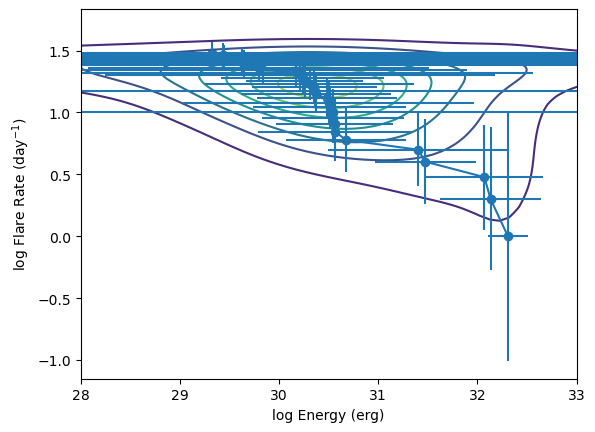

In [288]:
flare_durations=np.zeros(len(v2_starts))

for i in range(len(v2_starts)):
    flare_ind=range(v2_starts[i], v2_stops[i])
    
    flare_durations[i]= lc.time.value[flare_ind][-1] - lc.time.value[flare_ind][0]

x,y,xe,ye = FFD(EDs*u.day.to(u.second), dur=flare_durations, Lum=30,
                fluxerr=np.median(np.array(lc.flux_err.value))/np.median(np.array(lc.flux.value)))

im, xx, yy = FlareKernel(x,y,xe,ye)

plt.contour(xx, yy, im)
plt.errorbar(x,y, xerr=xe, yerr=ye)
plt.scatter(x,y)
plt.xlabel('log Energy (erg)')
plt.ylabel('log Flare Rate (day$^{-1}$)')
plt.xlim(28,33)
plt.show()